In [46]:
!pip install pypdf docx2txt unstructured msoffcrypto-tool openpyxl
!pip install -U langgraph


   ------------------------ --------------- 3/5 [langgraph-prebuilt]
   -------------------------------- ------- 4/5 [langgraph]
   ---------------------------------------- 5/5 [langgraph]



In [20]:
# Standard library imports
import os
import hashlib
from pathlib import Path
from typing import List

# Third-party imports
import numpy as np
import plotly.graph_objects as go
from dotenv import load_dotenv
from pydantic import Field
from sklearn.manifold import TSNE
import gradio as gr

from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableWithMessageHistory
from langchain_community.document_loaders import PyPDFLoader, TextLoader, Docx2txtLoader, UnstructuredExcelLoader
from langchain_community.document_loaders.excel import UnstructuredExcelLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import BaseRetriever, Document
from langchain.schema.vectorstore import VectorStoreRetriever
from langchain.callbacks.manager import CallbackManagerForRetrieverRun
from langchain.memory import ConversationBufferMemory
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.history_aware_retriever import create_history_aware_retriever

# LangChain integrations
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_core.runnables import RunnableLambda
from langchain.chains.conversational_retrieval.base import ConversationalRetrievalChain

from langchain_core.messages import HumanMessage
from langchain.memory import ChatMessageHistory
from langchain_core.runnables import RunnableWithMessageHistory
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain


In [21]:
# Load environment variables
load_dotenv(override=True)

# Configuration
DATA_PATH = r"your-data-path"
MODEL = "gpt-4o-mini"
CHROMA_PATH = "vector_db/chroma_insurellm"

# Explicitly access the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key:
    print("❌ OPENAI_API_KEY is missing")

In [22]:
# Load .pdf, .txt, and .md documents with metadata, excluding Jupyter checkpoints.

documents = []

def add_metadata(doc, file_path):
    doc.metadata["doc_type"] = file_path.parent.name
    doc.metadata["file_name"] = file_path.name
    if not doc.page_content.strip():
        print(f"⚠️ Empty content in {file_path}")
    # else:
    #     print(doc)
    #     print("-" * 40)
    return doc

for file_path in Path(DATA_PATH).rglob("*"):
    if ".ipynb_checkpoints" in file_path.parts:
        continue

    try:
        # Check file extension and load accordingly
        if file_path.name.endswith(".pdf"):
            loader = PyPDFLoader(str(file_path))
        elif file_path.name.endswith((".txt", ".md")):
            loader = TextLoader(str(file_path), encoding="utf-8")
        # NEW: Word (.docx) file
        elif file_path.name.endswith(".docx"):
            loader = Docx2txtLoader(str(file_path))
        # NEW: Excel (.xlsx) file
        elif file_path.name.endswith(".xlsx"):
            # Use UnstructuredExcelLoader for comprehensive parsing
            loader = UnstructuredExcelLoader(str(file_path))
        else:
            continue
        
        docs = loader.load()

    except Exception as e:
        print(f"❌ Skipped {file_path}: {e}")
        continue

    documents.extend([add_metadata(doc, file_path) for doc in docs])

print(f"{len(documents)} documents loaded." if documents else "No documents loaded.")


39 documents loaded.


In [23]:
# Split documents into smaller chunks with overlapping characters for better context.
text_splitter = CharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True  # Maintain chunk order (useful for context tracking)
)

# Load and split documents
chunks = text_splitter.split_documents(documents)

print(f"Split {len(documents)} documents into {len(chunks)} chunks.")

def generate_chunk_id(text):
    return hashlib.md5(text.encode("utf-8")).hexdigest()

# Add chunk_id to each chunk's metadata
for chunk in chunks:
    chunk.metadata["chunk_id"] = generate_chunk_id(chunk.page_content) # Create an MD5 hash of the chunk's content
    if not chunk.page_content.strip():
        print(f"⚠️ Empty chunk from: {chunk.metadata['file_name']}")

# Debug: print a few chunk metadatas to verify chunk_id is added
for i, chunk in enumerate(chunks[:2]):
    print(f"Chunk {i+1} metadata:", chunk.metadata)

Split 39 documents into 39 chunks.
Chunk 1 metadata: {'source': 'C:\\Users\\itomi\\projects\\llm_engineering\\projects\\RAG_QA_argent\\data\\analytics\\analytics_1.docx', 'doc_type': 'analytics', 'file_name': 'analytics_1.docx', 'start_index': 0, 'chunk_id': '81b77aec00451d0d40ec09167e4cd666'}
Chunk 2 metadata: {'source': 'C:\\Users\\itomi\\projects\\llm_engineering\\projects\\RAG_QA_argent\\data\\analytics\\analytics_2.txt', 'doc_type': 'analytics', 'file_name': 'analytics_2.txt', 'start_index': 0, 'chunk_id': 'cb4f628cfd9b1f67cce279bcc390855d'}


In [24]:
# Check for duplicate chunk IDs
chunk_ids = [chunk.metadata["chunk_id"] for chunk in chunks]
duplicate_ids = [chunk_id for chunk_id in chunk_ids if chunk_ids.count(chunk_id) > 1]

if duplicate_ids:
    print(f"Duplicate chunk IDs found: {duplicate_ids}")
else:
    print("No duplicate chunks.")

Duplicate chunk IDs found: ['69f33e0ecee440df080bb983e8bd0918', '69f33e0ecee440df080bb983e8bd0918']


In [25]:
embedding_function = OpenAIEmbeddings()
# By default, OpenAIEmbeddings() uses OpenAI's text-embedding-ada-002 model - a multilingual model

In [26]:
os.makedirs(CHROMA_PATH, exist_ok=True)

def get_existing_chunk_ids(db_path):
    try:
        db_existing = Chroma(persist_directory=db_path)
        results = db_existing._collection.get(include=["metadatas"])
        return set(
            m["chunk_id"] for m in results["metadatas"]
            if isinstance(m, dict) and "chunk_id" in m
        )
    except Exception as e:
        print("❌ Error loading existing chunk IDs:", e)
        return set()

# Get chunk_ids of current chunks
new_chunk_ids = set([chunk.metadata["chunk_id"] for chunk in chunks])

# Get existing chunk_ids from Chroma
existing_chunk_ids = get_existing_chunk_ids(CHROMA_PATH)

# Compare
if new_chunk_ids != existing_chunk_ids:
    print("Chunk changes detected. Rebuilding Chroma DB.")
    db = Chroma.from_documents(documents=chunks, embedding=embedding_function, persist_directory=CHROMA_PATH)
    print(f"Saved {len(chunks)} chunks to {CHROMA_PATH}.")
else:
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)
    print("Chroma DB is up to date. Skipping regeneration.")


Chunk changes detected. Rebuilding Chroma DB.
Saved 39 chunks to vector_db/chroma_insurellm.


In [27]:
collection = db._collection
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [
    ['blue', '#4B0082', 'red', '#8B4513', '#FF8C00', '#2F4F4F', '#228B22', '#4682B4', '#20B2AA', '#DAA520']
    [['product', 'sales', 'customer', 'company', 'news', 'contracts', 'employees', 'analytics', 'research', 'training'].index(t)]
    if t in ['product', 'sales', 'customer', 'company', 'news', 'contracts', 'employees', 'analytics', 'research', 'training']
    else 'gray'
    for t in doc_types
]

In [28]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=8, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='black'),
    xaxis=dict(gridcolor='lightgray', zerolinecolor='lightgray'),
    yaxis=dict(gridcolor='lightgray', zerolinecolor='lightgray'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40),
)


fig.show()

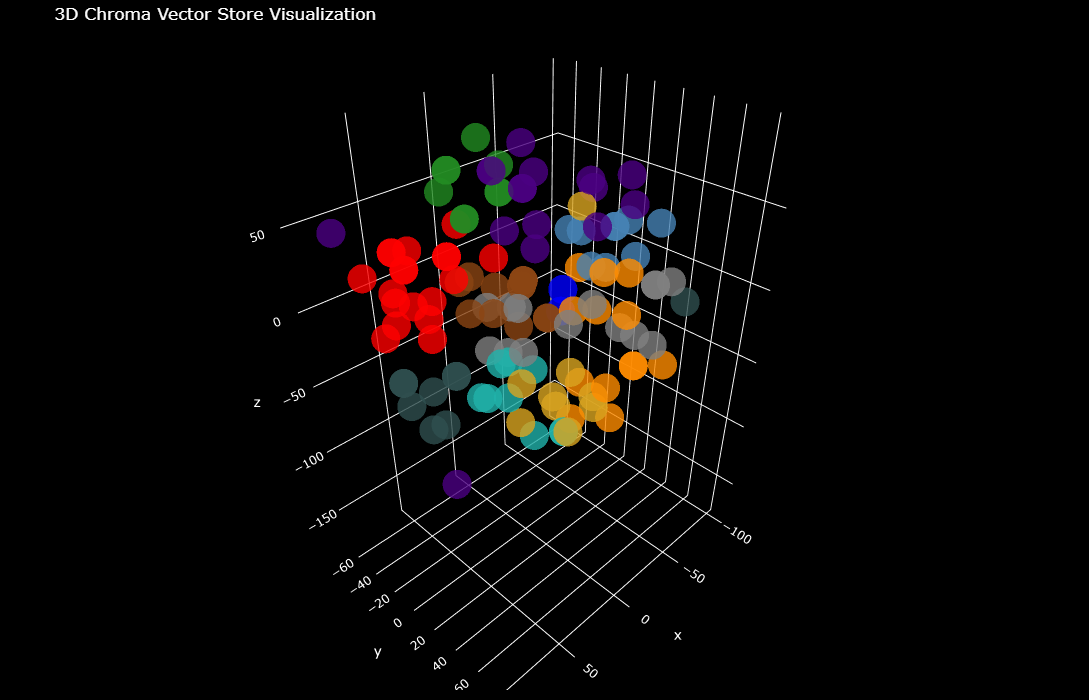

In [29]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=8, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    scene=dict(
        xaxis=dict(color='white', backgroundcolor='black', showbackground=True),
        yaxis=dict(color='white', backgroundcolor='black', showbackground=True),
        zaxis=dict(color='white', backgroundcolor='black', showbackground=True)
    ),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [30]:
similarity_threshold = 0.5

class MyVectorStoreRetriever(VectorStoreRetriever):
    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        docs_and_similarities = (
            self.vectorstore.similarity_search_with_relevance_scores(
                query, **self.search_kwargs
            )
        )

        # Make the score part of the document metadata
        for doc, similarity in docs_and_similarities:
            doc.metadata["score"] = similarity

        docs = [doc for doc, sim in docs_and_similarities if sim >= self.search_kwargs.get("score_threshold", 0)]
        return docs

retriever = MyVectorStoreRetriever(
   vectorstore=db,
   search_type="similarity_score_threshold",
   search_kwargs={"score_threshold": similarity_threshold, "k": 20},
)


# Add metadata to the context sentto the LLM
def inject_metadata(doc: Document) -> Document:
    doc_type = doc.metadata.get("doc_type", "Unknown")
    file_name = doc.metadata.get("file_name", "Unknown")
    content = f"[SOURCE: {doc_type} - {file_name}]\n{doc.page_content}"
    return Document(page_content=content, metadata=doc.metadata)

class MetadataInjectingRetriever(BaseRetriever):
    base_retriever: BaseRetriever = Field()

    def _get_relevant_documents(self, query: str):
        docs = self.base_retriever.get_relevant_documents(query)
        return [inject_metadata(doc) for doc in docs]

retriever = MetadataInjectingRetriever(base_retriever=retriever)

In [31]:
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

In [32]:
# Define your question
question = "Who are the top 3 earners in 2023 with base, bonus, and total. Include names."

system_prompt = """
You are an assistant that answers questions about the company Insurellm.

Use the following chat history and retrieved documents to answer.

Always base your answers strictly on the retrieved documents. If documents contain partial info, respond with what’s available. If there is no info, say so.

Do not invent names, roles, or facts.

You can use the document source information shown in the format [SOURCE: doc_type - file_name] if it helps you answer the question accurately.

Always extract exact numbers (like number of employees, years, revenue, etc.) from the documents if they are mentioned.

Chat History:
{chat_history}

Documents:
{context}

Question:
{input}
"""

# Create the prompt template
prompt = PromptTemplate(
    input_variables=["chat_history", "context", "input"],
    template=system_prompt
)

# Set up LLM and conversation chain (retriever is assumed to be defined elsewhere)
# llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# Create a history-aware retriever
history_aware_retriever = create_history_aware_retriever(
    llm=llm,
    retriever=retriever,
    prompt=ChatPromptTemplate.from_messages([
        MessagesPlaceholder(variable_name="chat_history"),
        ("user", "{input}"),
        ("user", "Given the above conversation, generate a search query to look up in order to get information relevant to the conversation. Only return the query itself, with no extra text.")
    ])
)

# Create a document combination chain
combine_docs_chain = create_stuff_documents_chain(
    llm,
    ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}")
    ])
)

# Create the main retrieval chain
retrieval_chain = create_retrieval_chain(history_aware_retriever, combine_docs_chain)

# Set up the history store and the conversation chain
store = {}
def get_session_history(session_id: str) -> ChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

# retrieval_chainの出力から、answerキーの値だけを抽出する新しいRunnableを定義
# このステップを挟むことで、RootListenersTracerが処理しやすい形式になります。
final_chain = retrieval_chain | (lambda x: x['answer'])

# Build the conversation chain with the new final_chain
conversation_chain = RunnableWithMessageHistory(
    final_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

# Invoke the chain with the correct input format
question = "Who are the top 3 earners in 2023 with base, bonus, and total. Include names."

response = conversation_chain.invoke(
    {"input": question},
    config={"configurable": {"session_id": "insurellm-session"}}
)

print("\n🧠 Answer:", response)


🧠 Answer: There is no information available regarding the top earners, their salaries, bonuses, or total earnings for 2023 in the retrieved documents.


In [33]:
# 1. Define your system prompt

system_prompt = """
You are an assistant that answers questions about the company Insurellm.

Use the following chat history and retrieved documents to answer. Always base your answers strictly on the retrieved documents. If documents contain partial info, respond with what’s available. If there is no info, say so.

You can use the document source information shown in the format [SOURCE: doc_type - file_name] if it helps answer the question accurately.

Extract exact numbers (like number of employees, years, revenue, etc.) from the documents if mentioned. Do not invent names, roles, or facts.

Behavior Guidelines:
- Respond only when the user asks a question or requests clarification.
- If the user greets you or expresses gratitude, respond warmly, but **avoid repeating the previous answer** unless explicitly requested for more details.
- If the user asks "thank you" or similar, acknowledge it with gratitude, but **do not provide the same answer again** unless further information is requested.
- If the user shares feedback, acknowledge it, thank them, and offer further assistance.
- If the user expresses frustration or confusion, empathize, clarify, and offer further support.
- If the user doesn't find a clear answer, encourage them to ask for clarification or provide additional details, and offer further assistance.

Chat History:
{chat_history}

Documents:
{context}

Question:
{question}
"""


In [34]:
# 2. Create the prompt template

prompt = PromptTemplate(
    input_variables=["chat_history", "context", "question"],
    template=system_prompt
)

In [35]:
# 3. Set up LLM, memory, retriever, and the updated chain

llm = ChatOpenAI(temperature=0.7, model_name=MODEL)
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True, output_key="answer")
conversation_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    combine_docs_chain_kwargs={"prompt": prompt}
)

def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    answer = ""
    for chunk in result["answer"]:
        answer += chunk
        yield answer

In [36]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
